# Analisis Risiko Saham TOBA, GEMS, dan BRMS menggunakan EVT
Dalam notebook ini, kita akan menghitung Value at Risk (VaR) pada saham TOBA, GEMS, dan BRMS menggunakan pendekatan **Extreme Value Theory (EVT)**. Metode ini mencakup dua pendekatan utama:
- Block Maxima (BM)
- Peaks Over Threshold (POT)

Kita juga akan melakukan eksplorasi data, uji distribusi, serta visualisasi hasil analisis.

In [73]:
# !pip install yfinance numpy pandas matplotlib scipy seaborn

In [74]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genextreme, genpareto, kstest
import seaborn as sns
from datetime import datetime

## Mengunduh Data Saham
Menggunakan pustaka `yfinance` untuk mendapatkan data saham **TOBA**, **GEMS**, dan **BRMS** dari Januari 2018 hingga Desember 2023.

In [75]:
tickers = ['NVDA', 'TSLA', 'AMD']
start_date = '2023-12-7'
end_date = '2024-12-7'

# Download data
data = yf.download(tickers, start=start_date, end=end_date)['Close']
data = data.dropna()
data.head()

[*********************100%***********************]  3 of 3 completed


Ticker,AMD,NVDA,TSLA
Date,,,
2023-12-07,128.369995,46.596001,242.639999
2023-12-08,128.919998,47.506001,243.839996
2023-12-11,134.410004,46.626999,239.740005
2023-12-12,137.610001,47.657001,237.009995
2023-12-13,138.190002,48.088001,239.289993


## Menghitung Return Saham
Return dihitung sebagai persentase perubahan harian dari harga penutupan.

In [76]:
returns = data.pct_change().dropna()
returns.head()

Ticker,AMD,NVDA,TSLA
Date,,,
2023-12-08,0.004285,0.019530,0.004946
2023-12-11,0.042585,-0.018503,-0.016814
2023-12-12,0.023808,0.022090,-0.011387
2023-12-13,0.004215,0.009044,0.009620
2023-12-14,-0.001375,0.005448,0.049145


## Eksplorasi Data
Melakukan visualisasi harga penutupan saham dan return saham.

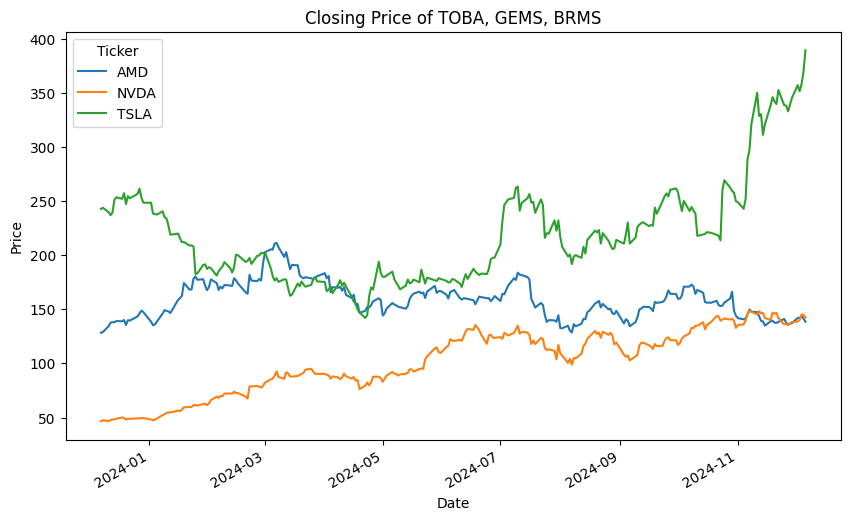

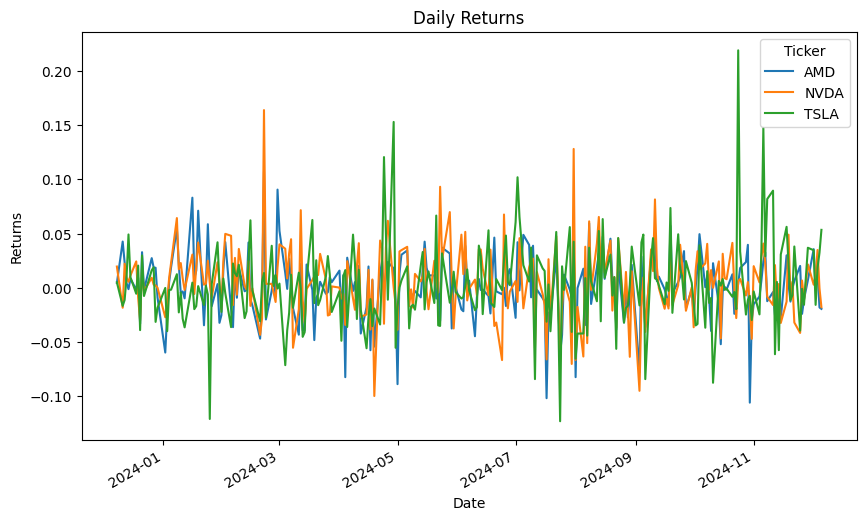

In [77]:
# Closing price plot
data.plot(figsize=(10, 6), title="Closing Price of TOBA, GEMS, BRMS", xlabel="Date", ylabel="Price")
plt.show()

# Returns plot
returns.plot(figsize=(10, 6), title="Daily Returns", xlabel="Date", ylabel="Returns")
plt.show()

## Identifikasi Heavy Tail
Menggunakan boxplot untuk melihat nilai ekstrem dan uji Kolmogorov-Smirnov untuk memeriksa distribusi normalitas.

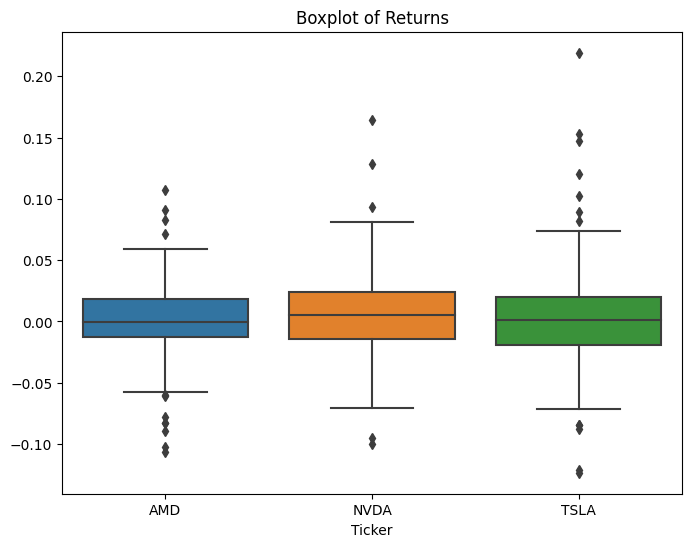

AMD: KS-Statistic=0.0782, P-value=0.0877
NVDA: KS-Statistic=0.0565, P-value=0.3853
TSLA: KS-Statistic=0.0795, P-value=0.0795


In [78]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=returns)
plt.title("Boxplot of Returns")
plt.show()

# Kolmogorov-Smirnov test for normality
for ticker in returns.columns:
    stat, p_value = kstest(returns[ticker], 'norm', args=(returns[ticker].mean(), returns[ticker].std()))
    print(f"{ticker}: KS-Statistic={stat:.4f}, P-value={p_value:.4f}")

## Pendekatan Block Maxima (BM)
Membagi data menjadi blok (misal, mingguan) dan mengestimasi parameter distribusi GEV.

In [79]:
block_size = 5  # Weekly data
bm_data = returns.groupby(np.arange(len(returns)) // block_size).max()

# Fit GEV distribution
gev_params = {}
for ticker in bm_data.columns:
    params = genextreme.fit(bm_data[ticker])
    gev_params[ticker] = params
    print(f"{ticker}: Shape={params[0]:.4f}, Loc={params[1]:.4f}, Scale={params[2]:.4f}")

AMD: Shape=0.1213, Loc=0.0263, Scale=0.0196
NVDA: Shape=0.0137, Loc=0.0279, Scale=0.0232
TSLA: Shape=-0.1288, Loc=0.0281, Scale=0.0258


### Menghitung Value at Risk (VaR) menggunakan GEV
Menggunakan distribusi GEV untuk menghitung VaR pada tingkat kepercayaan 95%.

In [80]:
confidence_level = 0.95
VaR_gev = {}
for ticker, params in gev_params.items():
    VaR_gev[ticker] = genextreme.ppf(1 - confidence_level, *params)
    print(f"VaR (GEV) for {ticker}: {VaR_gev[ticker]:.4f}")

VaR (GEV) for AMD: 0.0033
VaR (GEV) for NVDA: 0.0022
VaR (GEV) for TSLA: 0.0017


## Pendekatan Peaks Over Threshold (POT)
Mengidentifikasi nilai ekstrem berdasarkan ambang batas tertentu dan mengestimasi parameter GPD.

In [96]:
threshold = returns.quantile(0.95)  # 95% threshold
pot_data = {ticker: returns[returns[ticker] > threshold[ticker]][ticker] - threshold[ticker] for ticker in returns.columns}

# Fit GPD
gpd_params = {}
for ticker in pot_data.keys():
    params = genpareto.fit(pot_data[ticker])
    gpd_params[ticker] = params
    print(f"{ticker}: Shape={params[0]:.4f}, Loc={params[1]:.4f}, Scale={params[2]:.4f}")

AMD: Shape=1.3271, Loc=0.0004, Scale=0.0074
NVDA: Shape=1.3234, Loc=0.0004, Scale=0.0157
TSLA: Shape=1.2016, Loc=0.0008, Scale=0.0114


### Menghitung Value at Risk (VaR) menggunakan GPD
Menggunakan distribusi GPD untuk menghitung VaR pada tingkat kepercayaan 95%.

In [82]:
VaR_gpd = {}
for ticker, params in gpd_params.items():
    VaR_gpd[ticker] = threshold[ticker] + genpareto.ppf(1 - confidence_level, *params)
    print(f"VaR (GPD) for {ticker}: {VaR_gpd[ticker]:.4f}")

VaR (GPD) for AMD: 0.0474
VaR (GPD) for NVDA: 0.0505
VaR (GPD) for TSLA: 0.0628


In [95]:
def backtest(returns, VaR):
    violations = (returns < -VaR).sum()
    return violations

backtest_results = {ticker: backtest(returns[ticker], VaR_gpd[ticker]) for ticker in returns.columns}
